# Fetching crypto and tweets data.

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from CryptoApi import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)


# with open('crypto_token.txt','r') as f:
#     token = f.readline()
    
# crypto = CryptoApi(token)
# crypto.get_data('btc','usd','day',period_count=90)

# Analysis of tweets

In [2]:
# new_tweets_df = TweetScraper().fetch_data('2023-04-10','2023-06-09', frequency='d')
# cleaned_df = TweetCleaner().transform(new_tweets_df)
# nlp_model = LDA().fit(cleaned_df)
# cleaned_df = extract_topics(nlp_model.topics)

# new_btc_df = CryptoApi().fetch_data()
# cleaned_btc = CryptoCleaner().transform(new_btc_df)
# xgb_model = XGBoost().fit(cleaned_btc)

In [3]:
from DataPreparation.TextVectorizer import TextVectorizer
from DataPreparation.CryptoPreprocessor import CryptoPreprocessor
from DataPreparation.TweetPreprocessor import TweetPreprocessor
from gensim.models import LdaMulticore
from gensim.test.utils import datapath


tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
twt_prep = TweetPreprocessor(tweets_df)
mod_tweets_df = twt_prep.transform()

text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())

In [4]:
temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
crypto_prep = CryptoPreprocessor()
topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, btc_df)

Text(0.5, 1.0, 'open by month')

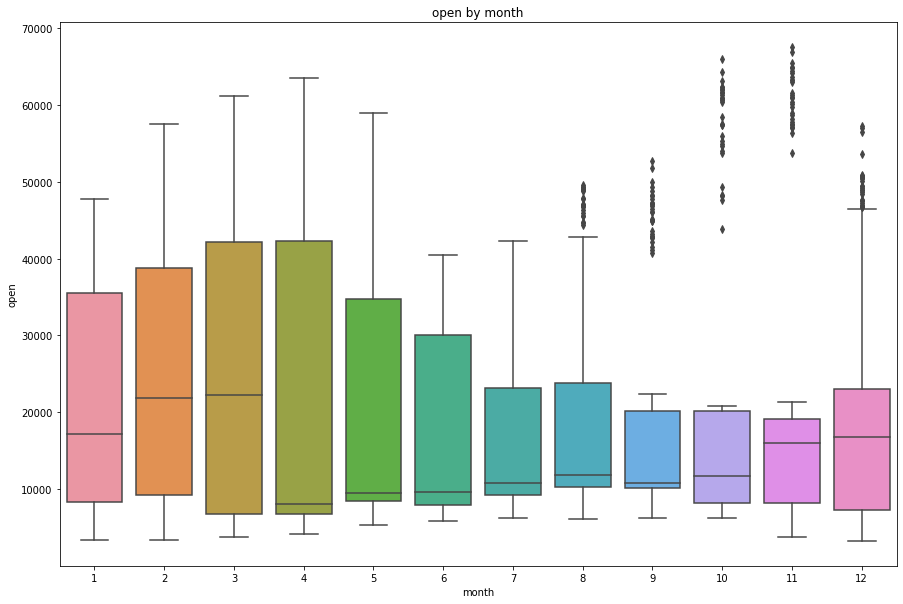

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=topics_btc, x='month',y='open')
ax.set_title('open by month')

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


X = topics_btc.drop(['close'], axis=1)
y = topics_btc['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=25)

[0]	validation_0-rmse:18814.69395	validation_1-rmse:18832.77980
[25]	validation_0-rmse:174.67377	validation_1-rmse:649.78592
[50]	validation_0-rmse:77.00941	validation_1-rmse:651.72962
[72]	validation_0-rmse:39.34444	validation_1-rmse:650.34338


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

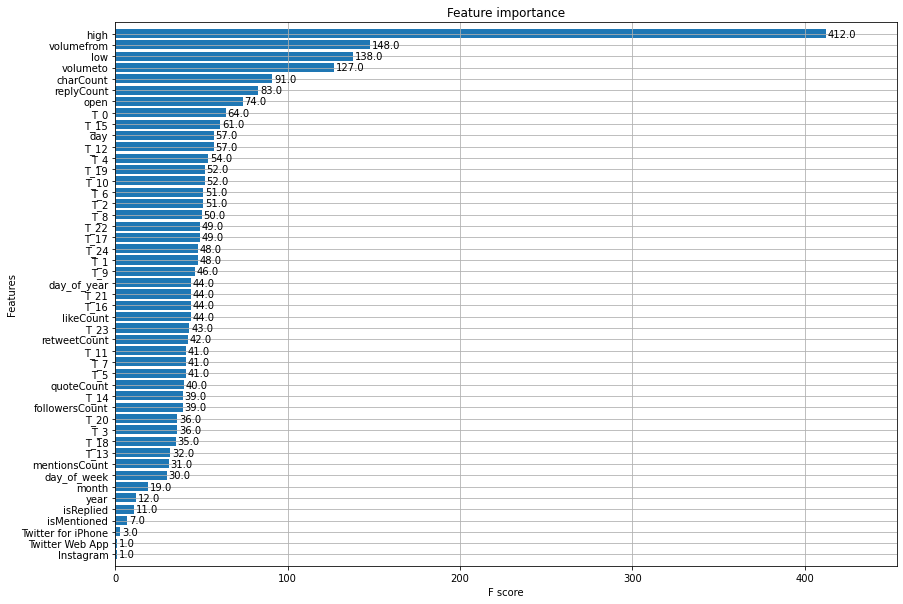

In [ ]:
ax = xgb.plot_importance(reg, height=0.8)
fig = ax.figure
fig.set_size_inches(14, 10)

In [ ]:
test = X_test.copy()

test['preds'] = reg.predict(X_test)
df = pd.DataFrame(y).merge(test[['preds']], how='inner', left_index=True, right_index=True)
df['absolute_error'] = abs(df['close'] - df['preds'])
df['percentage_error'] = abs(df['close'] - df['preds'])/df['close']*100
df

,close,preds,absolute_error,percentage_error
date,,,,
2017-11-19,8042.64,8138.889648,96.249648,1.196742
2017-12-17,19065.71,18898.597656,167.112344,0.876507
2018-01-09,14468.50,15577.051758,1108.551758,7.661829
2018-01-29,11233.95,11513.635742,279.685742,2.489647
2018-02-18,10417.23,10669.766602,252.536602,2.424220
...,...,...,...,...
2023-03-21,28185.99,27709.652344,476.337656,1.689980
2023-03-23,28345.69,28020.031250,325.658750,1.148883
2023-03-24,27491.73,28341.019531,849.289531,3.089255


In [ ]:
# X = topics_btc.drop(['close'], axis=1)
# y = topics_btc['close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest  = xgb.DMatrix(X_test, label=y_test)

# param = {'max_depth': 12, 'objective': 'reg:squarederror'}
# param['nthread'] = 8
# param['eval_metric'] = 'mape'
# #param['eval_metric'] = 'auc'
# evallist = [(dtrain, 'train'), (dtest, 'test')]

# num_round = 30
# bst = xgb.train(param, dtrain, num_round, evals=evallist)

In [ ]:
# ax = xgb.plot_importance(bst, height=0.8)
# fig = ax.figure
# fig.set_size_inches(14, 10)

In [ ]:
#TODO: make tracker for features that were dropped due to high sparsity in case of leaving threshold of 50% sparsity
# for future model upgrading and adding new features.

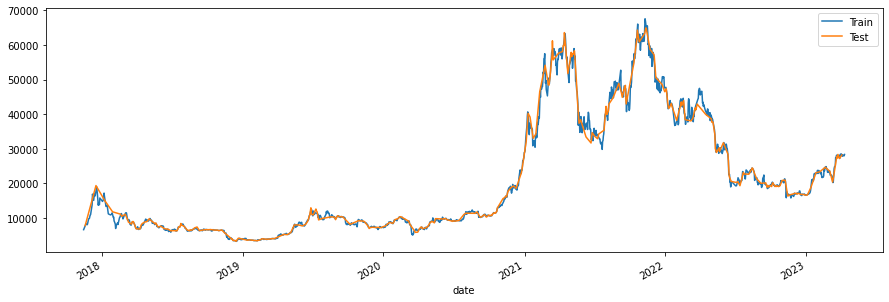

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,5))
X_train['open'].plot(ax=ax, label='Train set')
X_test['open'].plot(ax=ax, label='Test set')
# ax.axvline('', color='black', ls='--')
ax.legend(['Train','Test'])
plt.show()